In [1]:
import torch
from ml4gw.waveforms import sine_gaussian
from lalinference import BurstSineGaussian
import numpy as np
import matplotlib.pyplot as plt

/home/ethan.marx/miniconda3/envs/ml4gw-RDr5yYl2-py3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sample_rate = 2048
duration = 2

In [3]:
qualities = torch.tensor([3, 10, 100])
frequencies = torch.tensor([10, 500, 800])
hrsss = torch.tensor([1e-22, 1e-21, 1e-20])
phases = torch.tensor([0, np.pi / 2, np.pi])
eccentricities = torch.tensor([0, 0.5, 1])

In [4]:
# calculate waveforms with torch implementation
waveforms = sine_gaussian(
    qualities,
    frequencies,
    hrsss,
    phases,
    eccentricities,
    sample_rate,
    duration,
)

# calculate waveforms with lalsimulation implementation
# and compare to torch version
for i in range(len(qualities)):
    quality = qualities[i].item()
    frequency = frequencies[i].item()
    hrss = hrsss[i].item()
    phase = phases[i].item()
    eccentricity = eccentricities[i].item()
    waveform = waveforms[i]

    # calculate waveform with lalsimulation
    hplus, hcross = BurstSineGaussian(
        Q=quality,
        centre_frequency=frequency,
        hrss=hrss,
        eccentricity=eccentricity,
        phase=phase,
        delta_t=1 / sample_rate,
    )
    hplus = hplus.data.data
    hcross = hcross.data.data

    # compare hplus and hcross polarizations
    torch_polarizations = waveform.numpy()
    n_samples = len(hplus)
    start, stop = torch_polarizations.shape[-1] // 2 - n_samples // 2, torch_polarizations.shape[-1] // 2 + n_samples // 2 + 1
    torch_polarizations = torch_polarizations[..., start:stop]

    assert np.allclose(torch_polarizations[0], hplus, atol=1e-25)
    assert np.allclose(torch_polarizations[1], hcross, atol=1e-25)

    # plot waveforms
    plt.figure()
    plt.plot(torch_polarizations[0], label='torch')
    plt.plot(hplus, label='lalsimulation')

    plt.legend()
    plt.show()
    
    

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

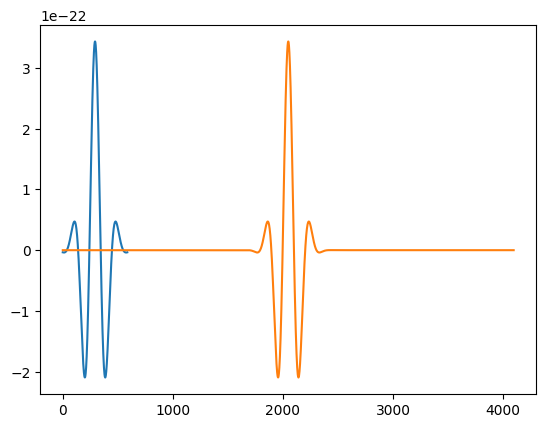

In [5]:
plt.plot(hplus)
plt.plot(waveforms[0][0].numpy())

In [21]:
def tukey_window(N: int, alpha = torch.Tensor):
    n = torch.arange(0, N)
    n = n.repeat(len(alpha), 1)
    width = torch.floor(alpha*(N-1)/2.0).int()
    print(width.shape, n.shape)
    
    n1 = n[:, 0:width+1]
    n2 = n[:, width+1:N-width-1]
    n3 = n[:, N-width-1:]

    w1 = 0.5 * (1 + torch.cos(torch.pi * (-1 + 2.0*n1/alpha/(N-1))))
    w2 = torch.ones(n2.shape)
    w3 = 0.5 * (1 + torch.cos(torch.pi * (-2.0/alpha + 1 + 2.0*n3/alpha/(N-1))))

    w = torch.cat((w1, w2, w3))

    return w

In [22]:
tukey_window(100, alpha=torch.tensor([0.1, 0.2]))

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
         72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
         90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
         72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
         90, 91, 92, 93, 94, 95, 96, 97, 98, 99]]) torch.Size([2, 100])
torch.Size([2]) torch.Size([2, 100])


TypeError: only integer tensors of a single element can be converted to an index

In [26]:
N = 100 
alpha = torch.Tensor([0.1, 0.2])
n = torch.arange(0, N)
n = n.repeat(len(alpha), 1)

In [30]:
n[:, torch.arange(10)]

tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])